# 프로젝트 : 주식 예측에 도전해 보자

#### 배경
- 예측을 위한 시계열 데이터의 `안전성(stationarity)`을 정성적, 정량적인 방법으로 확인해본다.
- 안전성이 없을 경우 `seasonal_decompose()`를 통해 안정성을 확보한다.
- ARIMA 모델을 선언하고 필요 최적의 파라미터를 여러 실험을 통해 확보한다.
- ARIMA 모델을 통해 예측해본다.

## STEP 1 : 시계열 데이터 준비

- 삼성전자 주식 데이터의 '종가'(Close)만 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
path = os.getenv("HOME") + '/aiffel/stock_prediction/data/005930.KS.csv'
temp_df = pd.read_csv(path, index_col='Date', parse_dates=True)

ts = temp_df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
len(ts)

250

## STEP 2 : 각종 전처리 수행

In [3]:
# 혹시 결측치가 있으면 'time' method 파라미터 값을 통해 보간한다.
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

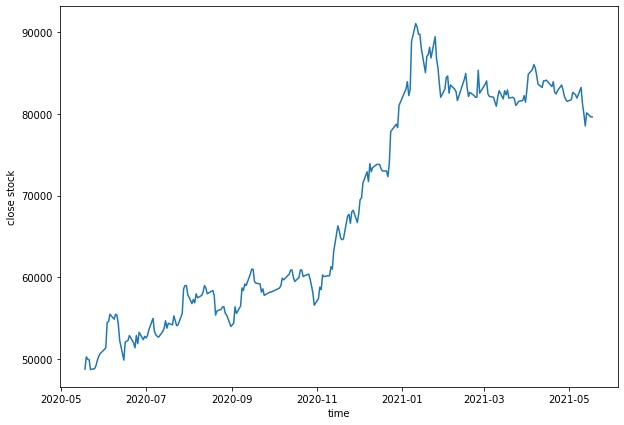

In [4]:
# 시각화로 현재 데이터의 time step별 추이를 확인해본다.
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 7]
plt.figure()
plt.plot(ts)
plt.xlabel('time')
plt.ylabel('close stock')
plt.show()

> #### note:
> - 현재 갈수록 평균도 올라가지만 분산도 일정하지 않은 것이 보인다.
> - log 변환을 해보면 좋을 것 같다.

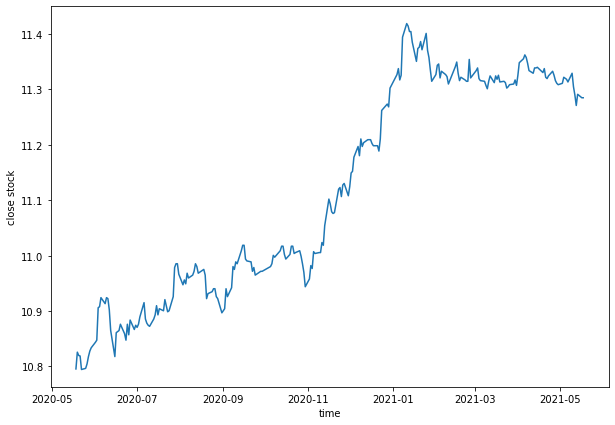

In [5]:
ts_log = np.log(ts)

plt.figure()
plt.plot(ts_log)
plt.xlabel('time')
plt.ylabel('close stock')
plt.show()

> #### feedback:
> - 분산을 줄인 효과는 별로 없는 것 같다...
> - 로그 변환의 의미에 대해 좀 더 찾아보고 `회고` 부분에서 적어봐야겠다.
> - 현재는 로그 변환한 데이터를 사용해보겠다.

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test 진행
- 안정적이지 않을 경우...
  - 시계열 분해(Times series decomposition) 진행
  - Residual의 안정성 확인

In [6]:
# 원본 데이터,
# 데이터 이동 평균,
# 데이터 이동 표준편차 그래프 그리는 함수 선언
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [7]:
# adfuller 모듈을 통해 통계적 수치만 있는 튜플을 반환 받고,
# 해당 수치들에 맞는 인덱스와 함께 정리해주는 함수 선언
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


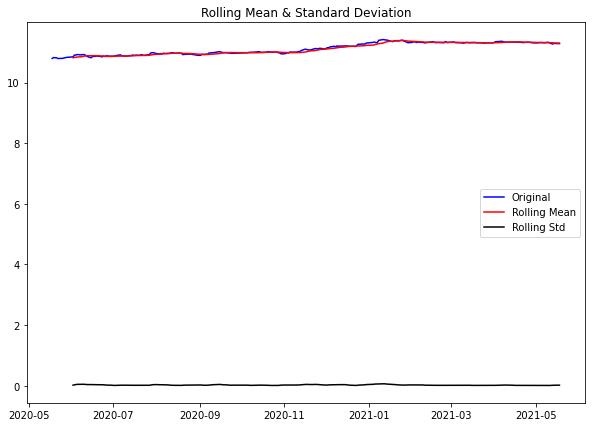

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


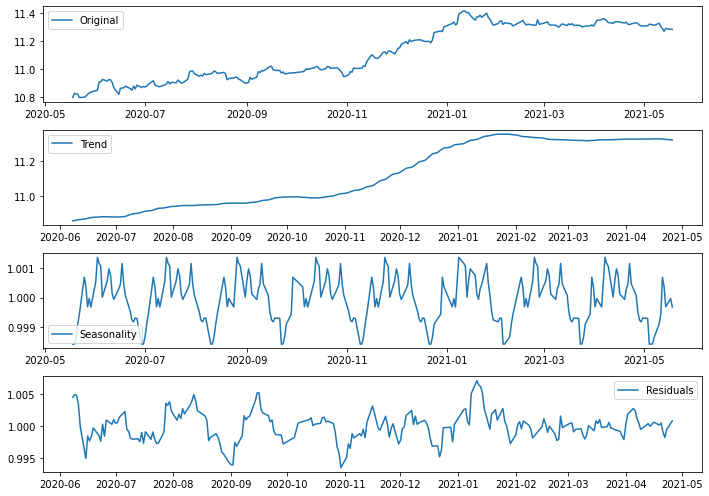

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

> #### feedback:
> - 맨 윗 그래프의 경우 std와 다른 값들의 차이가 커서 다른 값들이 잘 보이지 않는다.
> - 따로 떼어 내어서 확인해봐야겠다.

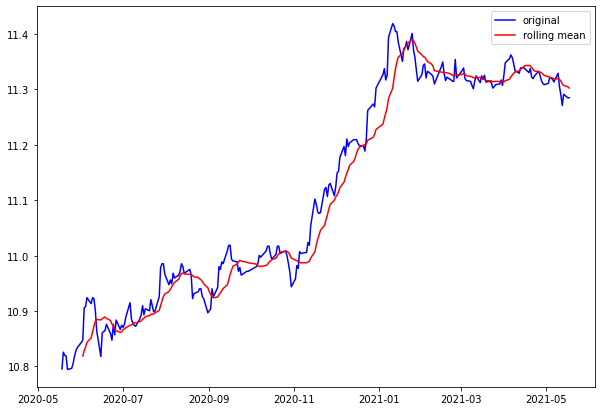

In [9]:
temp_rollmean = ts_log.rolling(window=12).mean()

plt.plot(ts_log, color='blue', label='original')
plt.plot(temp_rollmean, color='red', label='rolling mean')
plt.legend(loc='best')
plt.show()

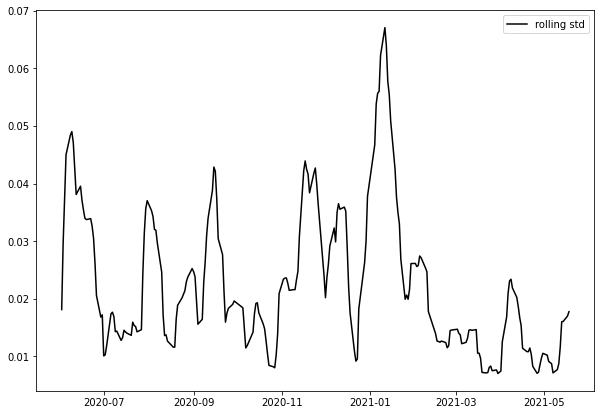

In [10]:
temp_rollstd = ts_log.rolling(window=12).std()

plt.plot(temp_rollstd, color='black', label='rolling std')
plt.legend(loc='best')
plt.show()

> #### feedback:
> - 일단 seasonal_decompose에서 `period=30`일 때의 결과이다.(월별을 의미하는 듯)
> - 위에서 부터 보면, 정량적으로 p-value가 0.59로서 아직 안정성이 확보되지 않았음을 바로 알 수 있고,
> - trend는 증가 추세임을 알 수 있으며,
> - 약 2달 간격으로 seasonality 패턴이 보이는 것이 그래프에서 확인된다.
> - **해당 데이터는 시계열 안정성이 보이지 않고 있다.**
> #### `ts_log`에서 trend와 seasonality가 빠진 residual의 경우 어떤 모양새를 보이는지 확인해보자

In [11]:
# 시간과 연계되어 평균과 분산에 영향을 주던 trend를 없애고,
# 일반적이지 않지만 주기적으로 나타나는 seasonality를 없앤
# Residual의 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


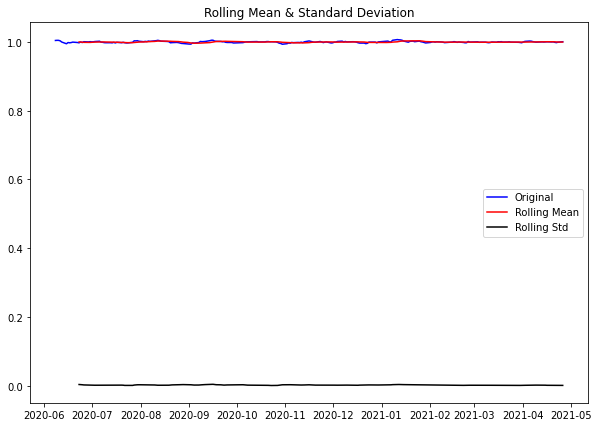

In [12]:
# 그래프로 residual의 안정성 확인
plot_rolling_statistics(residual, window=12)

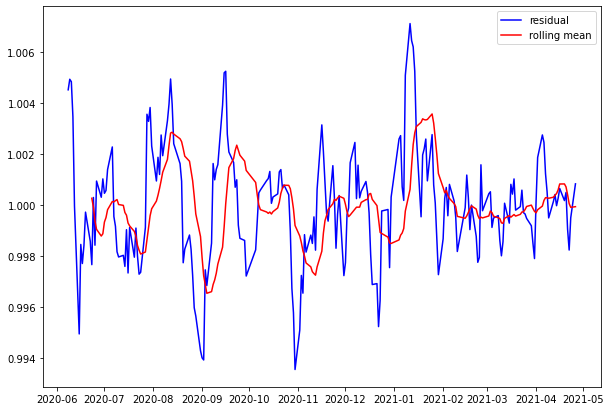

In [13]:
# 따로 떼어서 확인
temp_rollmean = residual.rolling(window=12).mean()

plt.plot(residual, color='blue', label='residual')
plt.plot(temp_rollmean, color='red', label='rolling mean')
plt.legend(loc='best')
plt.show()

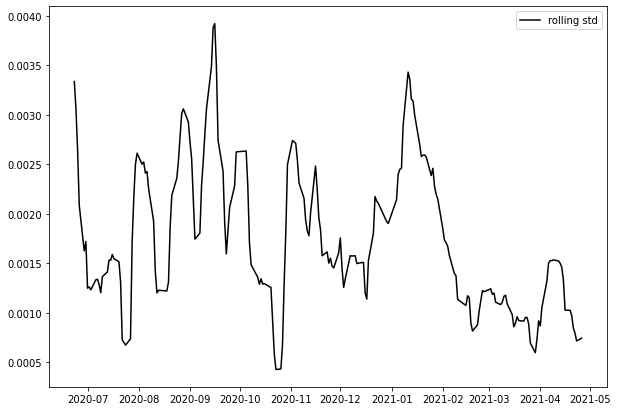

In [14]:
temp_rollstd = residual.rolling(window=12).std()

plt.plot(temp_rollstd, color='black', label='rolling std')
plt.legend(loc='best')
plt.show()

> #### feedback:
> - 그래프에서 어느 정도 일정한 수준으로 유지되는 안정성이 다소 보이는 것으로 생각되고,
> - p-value 또한 굉장히 낮아진 것을 확인할 수 있다.
> ##### 결론적으로 현 시점의 residual은 안정성이 확보된 데이터로 봐도 무방한 것 같다.
> ##### 그러나 이런 residual 데이터는 나중에 모델을 통해 예측 후 `원래 스케일로 키우는 것에 복잡성이 있어서 어렵단다`. 그래서 차분(differencing)한 데이터를 모델에 넣을 예정이다.
> ##### 차분한 데이터를 구해보자

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


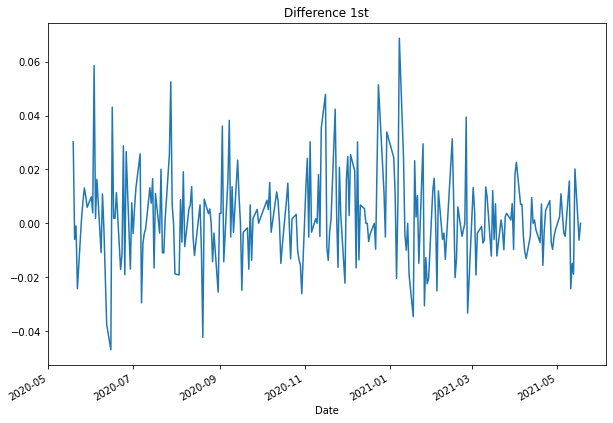

In [15]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [16]:
# 차분한 방법이 맞나 확인
test_diff = ts_log - ts_log.shift()
test_diff.dropna(inplace=True)

# 같지 않다는 False가 있으면 True를 내뱉고, 두 시리즈가 같으면 False를 내뱉습니다.
False in test_diff == diff_1

False

> #### feedback:
> - 1차 차분한 결과 Test Statistic과 p-value가 압도적으로 낮아서 안정성이 확보된 것으로 보인다.
> ##### 해당 1차 차분한 데이터를 ARIMA에 넣는 데이터로 하겠다.

## STEP 4 : 학습, 테스트 데이터셋 생성

In [17]:
# diff_1 확인
diff_1.describe()

count    249.000000
mean       0.001965
std        0.017218
min       -0.046975
25%       -0.009091
50%        0.001190
75%        0.010785
max        0.068752
Name: Close, dtype: float64

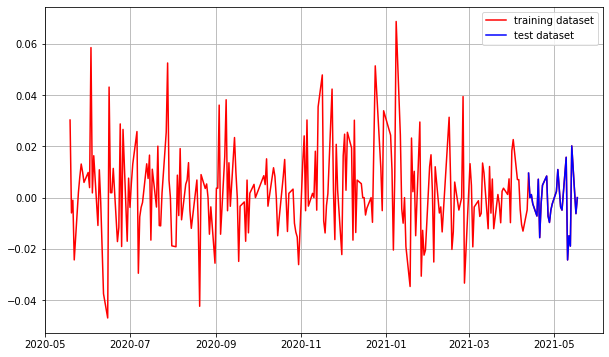

In [18]:
train_diff_1, test_diff_1 = diff_1[:int(len(diff_1)*0.9)], diff_1[int(len(diff_1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(diff_1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 original data를 선택
plt.plot(test_diff_1, c='b', label='test dataset')
plt.legend()


## STEP 5 : 적정 ARIMA 모수 찾기
- 현재 1차 차분한 데이터를 통해 차분 안정성에 대한 값은 찾았다.(1차 차분한 데이터를 그대로 사용할 예정이니 `d` 값은 `0`으로 넣으면 되는 것으로 판단)
- p, q를 찾기 위해 ACF, PACF 그래프를 그려보자

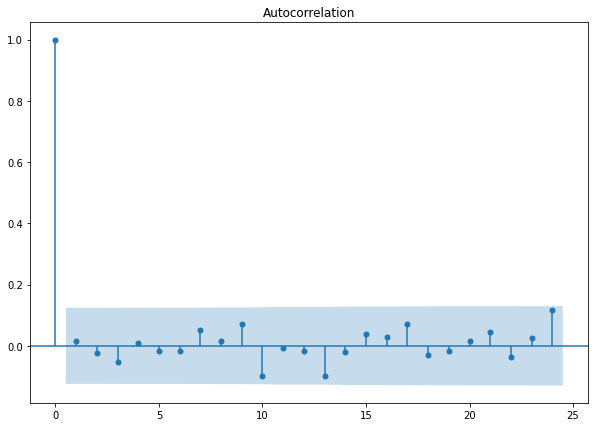

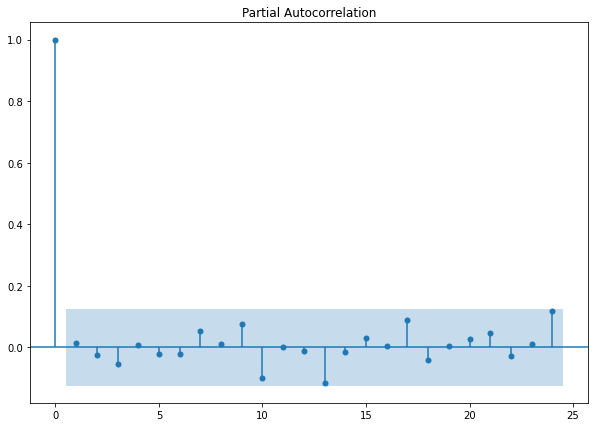

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

> #### feedback:
> - 이 경우 모든 시차에서 0값 범위에 속하게 되는데 `diff_1`은 그러면 white noise란다.
> - white noise의 경우 데이터 간 서로 아무 상관 없는 random 데이터여서 predict할 수 없는 것이란다...
> ##### 그냥 `ts_log`를 넣었을 때 어떤 그래프가 나오는지 확인해보자.

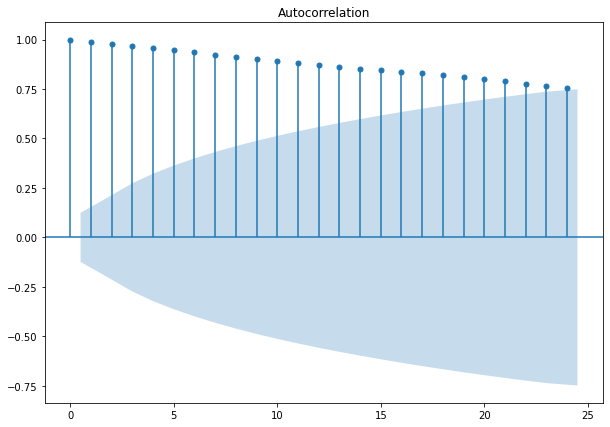

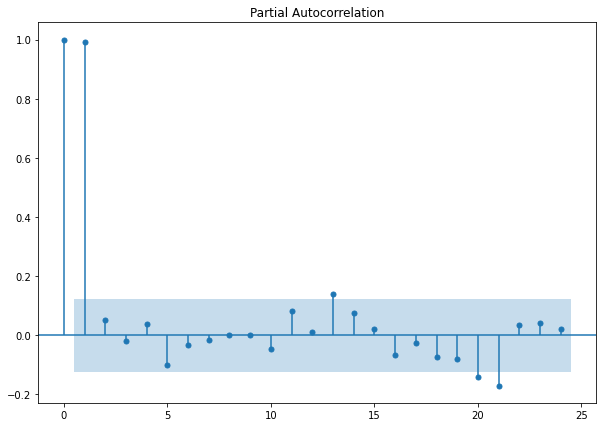

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

> #### feedback:
> - ACF가 저렇게 느리게 수렴하는 건 안정성이 확보되지 않은 데이터라고 한다.
> - 이해한바로 안정성을 가지지 않은 데이터는 ARIMA 모델에 넣을 수 없다고 한다...
> - 그러면 어떤 데이터를 넣어야 하는 것일까.....
> ##### 그래도 혹시 ARIMA(1, 0, 0)모델로 넣으면 안정성을 확보한 데이터 같이 변환되어 predict되는 것일 수도 있으니(? 개인적인 추측..) `ts_log`를 넣어서 진행해보도록 하겠다.

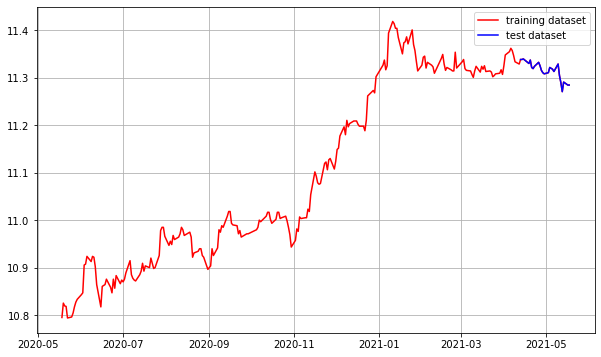

In [21]:
# train, test 데이터 나누기
train_ts_log, test_ts_log = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 original data를 선택
plt.plot(test_ts_log, c='b', label='test dataset')
plt.legend()


## STEP 6 : ARIMA 모델 훈련과 테스트

In [22]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_ts_log, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 583.082
Date:                Wed, 16 Feb 2022   AIC                          -1160.164
Time:                        00:40:05   BIC                          -1149.916
Sample:                             0   HQIC                         -1156.028
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.115     96.195      0.000      10.864      11.316
ar.L1          0.9937      0.006    168.571      0.000       0.982       1.005
sigma2         0.0003   2.45e-05     13.135      0.0

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


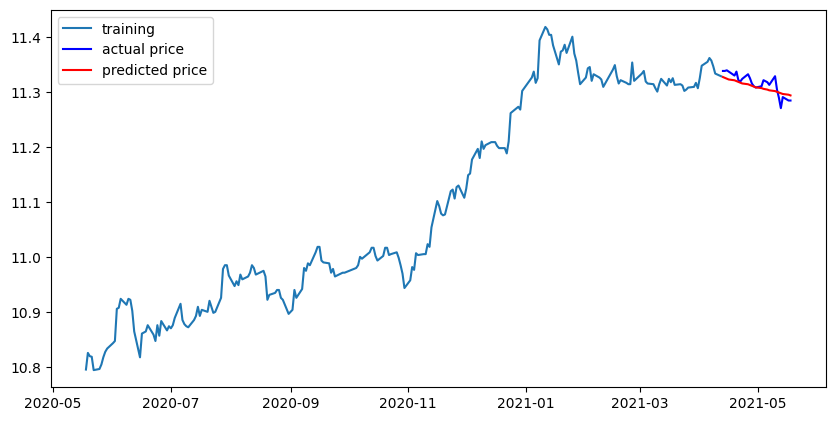

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_ts_log), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_ts_log.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_ts_log, label='training')
plt.plot(test_ts_log, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

> #### feedback:
> - 굉장히 형편 없음을 알 수 있다.
> - 베이스라인이라 치고 `MAPE`까지 구해보자.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_ts_log), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_ts_log), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_ts_log), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_ts_log))/np.abs(np.exp(test_ts_log)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1078734.6873193325
MAE:  866.9125685448345
RMSE:  1038.6215322817704
MAPE: 1.05%


> #### feedback:
> - MSE, MAE가 압도적으로 크게 나오는 건 이해하는데 왜 MAPE가 낮게 나오는 건지 모르겠다.(아무리 찾아봐도 왜 그런지 모르겠다. 낮은 MAPE를 이렇게 쉽게 구할 수 있는 것인가........?)
> - 인터넷에 찾아보니 저런 식이면 실제 데이터와 예측 데이터 간 약 `1.05%`의 차이만 있다는 건데 맞나..........?
> ##### 다른 p, d, q 값을 쓴 ARIMA 모델로 예측을 해보자.

In [25]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_ts_log, order=(2, 0, 0)) # order를 (1, 0, 0)에서 p를 올려봤다.  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 583.409
Date:                Wed, 16 Feb 2022   AIC                          -1158.817
Time:                        00:40:06   BIC                          -1145.153
Sample:                             0   HQIC                         -1153.302
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.132     83.895      0.000      10.831      11.349
ar.L1          1.0296      0.061     16.764      0.000       0.909       1.150
ar.L2         -0.0350      0.062     -0.562      0.5

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


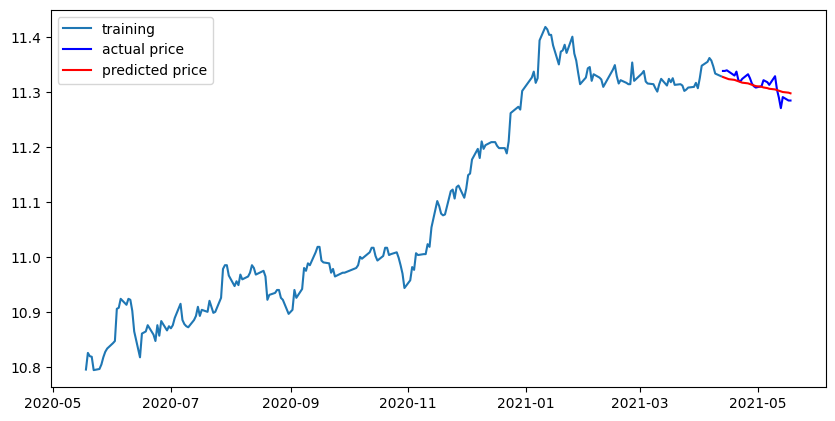

In [26]:
fc2 = fitted_m.forecast(len(test_ts_log), alpha=0.05)  # 95% conf
fc2 = np.array(fc2)
# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_ts_log.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_ts_log, label='training')
plt.plot(test_ts_log, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.legend()
plt.show()

> #### note:
> - 지표를 나타내는 것들을 모아서 함수로 만들어 볼 예정이다.

In [27]:
def stats(forecast, actual):
    mse = mean_squared_error(np.exp(actual), np.exp(forecast))
    mae = mean_absolute_error(np.exp(actual), np.exp(forecast))
    rmse = math.sqrt(mean_squared_error(np.exp(actual), np.exp(forecast)))
    mape = np.mean(np.abs(np.exp(actual) - np.exp(forecast))/np.abs(np.exp(forecast)))
    
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('MAPE: {:.2f}%'.format(mape*100))
    return mse, mae, rmse, mape

In [28]:
# order=(2, 0, 0)로 훈련한 모델의 예측 값 MAPE 출력
stats(fc2, test_ts_log)

MSE:  1052831.395368786
MAE:  840.3252917506424
RMSE:  1026.0757259426744
MAPE: 1.03%


(1052831.395368786, 840.3252917506424, 1026.0757259426744, 0.01027851451823867)

In [29]:
mse = mean_squared_error(np.exp(test_ts_log), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_ts_log), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_ts_log), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc2) - np.exp(test_ts_log))/np.abs(np.exp(test_ts_log)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1052831.395368786
MAE:  840.3252917506424
RMSE:  1026.0757259426744
MAPE: 1.02%


> ##### 사실 코드가 같은데 왜 보이는 값이 다른지 모르겠다.....
> ##### 그리고 저 형편없는 예측의 `MAPE`가 굉장히 낮다......(뭐가 잘못된 건지 원래 저게 맞는 건지 모르겠다)
> #### note:
> - 도대체 어떻게 `p, d, q`를 논리적으로 구하고 예측값을 낼 수 있을까...?
> - 일단 목표는 저 예측 그래프가 어느 정도 time series 같이 꺾이게 나오는 걸 봐보고 싶다.
> - 위에서는 `ts_log`의 ACF 그래프를 보면 안정성이 없다고 나오는데, 그것 때문에 애초에 이 데이터는 예측에 쓸 수 없는 데이터였을 수도 있다.
> - 하지만 궁금하니까 `ts_log`로 q 값에 23을 넣어보자(시차 23 이후부터 범위에 들어가는 것으로 보여서...)

In [30]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_ts_log, order=(0, 0, 23))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(0, 0, 23)   Log Likelihood                 570.721
Date:                Wed, 16 Feb 2022   AIC                          -1091.442
Time:                        00:40:12   BIC                          -1006.039
Sample:                             0   HQIC                         -1056.973
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0838      0.038    289.986      0.000      11.009      11.159
ma.L1          1.2580      0.070     18.095      0.000       1.122       1.394
ma.L2          1.4018      0.106     13.186      0.0

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


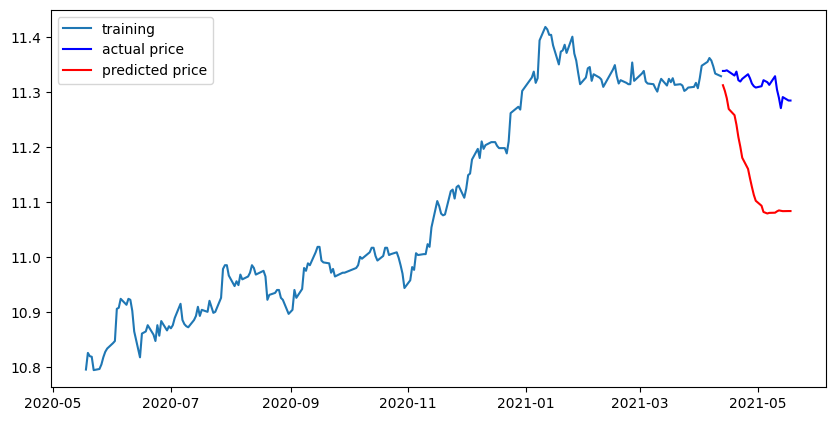

In [31]:
fc3 = fitted_m.forecast(len(test_ts_log), alpha=0.05)  # 95% conf
fc3 = np.array(fc3)
# Make as pandas series
fc_series3 = pd.Series(fc3, index=test_ts_log.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_ts_log, label='training')
plt.plot(test_ts_log, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
stats(fc3, test_ts_log)

MSE:  169320857.3883689
MAE:  12091.547381564676
RMSE:  13012.334816948452
MAPE: 17.90%


(169320857.3883689, 12091.547381564676, 13012.334816948452, 0.1790389553632896)

> #### feedback:
> - 저 정도는 되어야 `MAPE`도 안 좋게 나오나 보다....
> ##### 그냥 다른 종목의 예측으로 넘어가자....

### 테슬라 종목으로 시계열 데이터 예측해보기

In [33]:
!pip install yfinance

     |████████████████████████████████| 63 kB 348 kB/s  eta 0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8488 sha256=0d689492d292acba20c8778aa0dda8639420f9cc50b9c747170a4d13bcdcd16b
  Stored in directory: /aiffel/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [34]:
import yfinance as yf
print(yf.__version__)

0.1.70


In [35]:
# Tesla를 사용할 예정
tsla = yf.Ticker('TSLA')
tsla_data = tsla.history(period='3y') # 3년치 사용

# Close 데이터만 사용
tsla_series = pd.Series(tsla_data['Close'])
tsla_series.head()

Date
2019-02-19    61.127998
2019-02-20    60.512001
2019-02-21    58.245998
2019-02-22    58.942001
2019-02-25    59.754002
Name: Close, dtype: float64

In [36]:
# 결측치를 확인해보자
tsla_series[tsla_series.isna()]

Series([], Name: Close, dtype: float64)

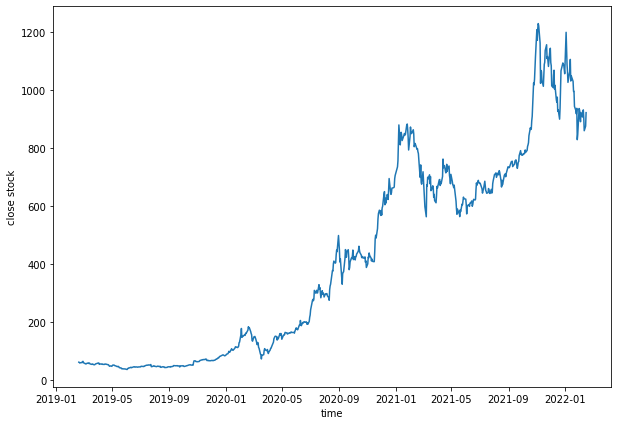

In [37]:
# 오리지널 데이터의 추이를 확인해보자
plt.figure()
plt.plot(tsla_series)
plt.xlabel('time')
plt.ylabel('close stock')
plt.show()

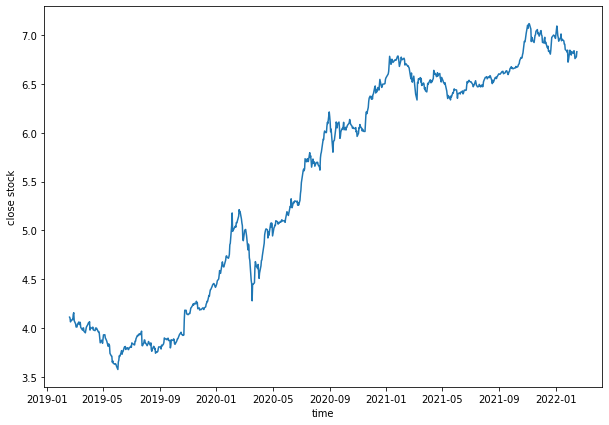

In [38]:
# 로그 변환하면 어떤지도 확인해보자
tsla_log = np.log(tsla_series)

plt.figure()
plt.plot(tsla_log)
plt.xlabel('time')
plt.ylabel('close stock')
plt.show()

> #### feedback:
> - 우상향 그래프로서 중간중간 큰 분산의 변화도 눈에 띈다.
> ##### 로그변환한 데이터를 갖고 안정성을 확보해보자!

#### 시계열 안정성 분석

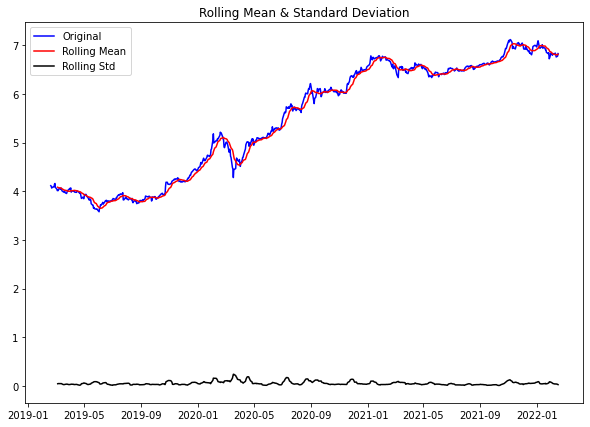

Results of Dickey-Fuller Test:
Test Statistic                  -0.536496
p-value                          0.884696
#Lags Used                       0.000000
Number of Observations Used    755.000000
Critical Value (1%)             -3.439041
Critical Value (5%)             -2.865376
Critical Value (10%)            -2.568813
dtype: float64


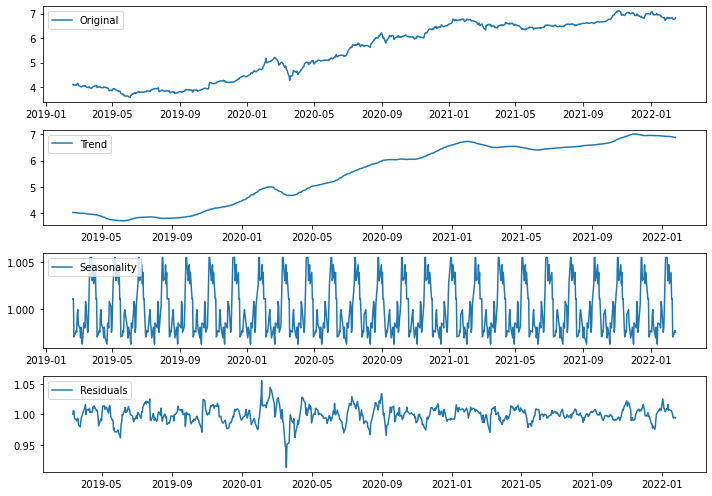

In [39]:
# 정성적 그래프 분석
plot_rolling_statistics(tsla_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(tsla_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tsla_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tsla_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

> #### feedback:
> - 정량적으로 높은 p-value를 갖고 있다.
> - trend와 seasonality가 강하게 끼어 있는 것을 그래프를 통해 확인할 수 있다.

#### ACF, PACF 그려보기

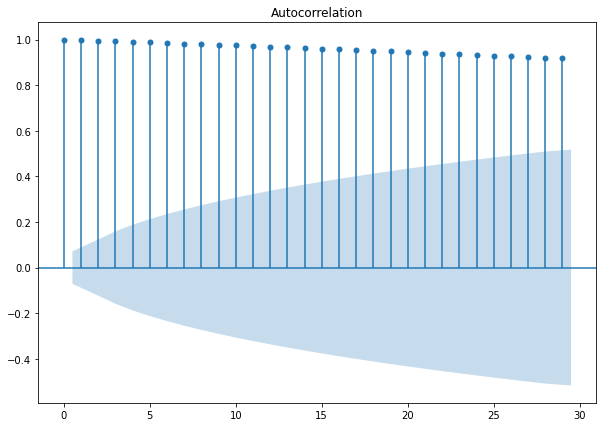

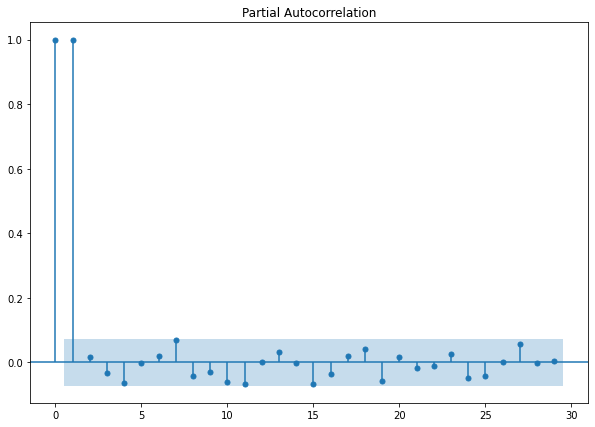

In [40]:
plot_acf(tsla_log)
plot_pacf(tsla_log)
plt.show()

> #### feedback:
> - 저런 패턴의 데이터는 아까도 사용해봤지만 좋은 예측이 되지않는다...
> - 결론적으로 진짜 **시계열 안정성을 가진 데이터**를 넣어봐야 ACF, PACF 그래프를 그리는 것도 유의미하지 않을까 싶다.
> ##### 그렇다면 저기서 residual의 안정성을 확인해보고 residual이 안정성이 있다면 예측값 복원에 어렵다지만 residual을 사용해보자!

Results of Dickey-Fuller Test:
Test Statistic                -8.198616e+00
p-value                        7.333268e-13
#Lags Used                     7.000000e+00
Number of Observations Used    7.180000e+02
Critical Value (1%)           -3.439490e+00
Critical Value (5%)           -2.865574e+00
Critical Value (10%)          -2.568918e+00
dtype: float64


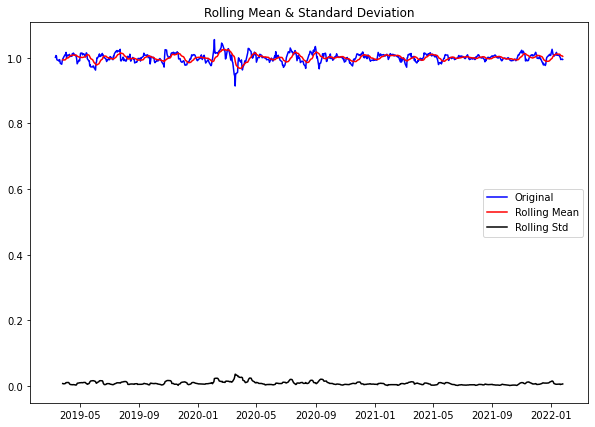

In [41]:
# residual의 NaN 값 없애주기
residual.dropna(inplace=True)

# residual의 정성적, 정량적 안정성 확인
augmented_dickey_fuller_test(residual)

plot_rolling_statistics(residual, window=12)

> #### feedback:
> - 안정성이 있다고 판단되니 residual로 ACF, PACF 그래프를 그려보고 모델에 넣어보자

#### ACF, PACF 그래프 그리기

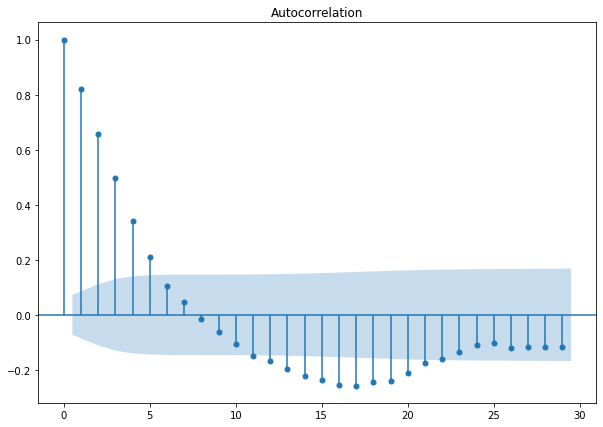

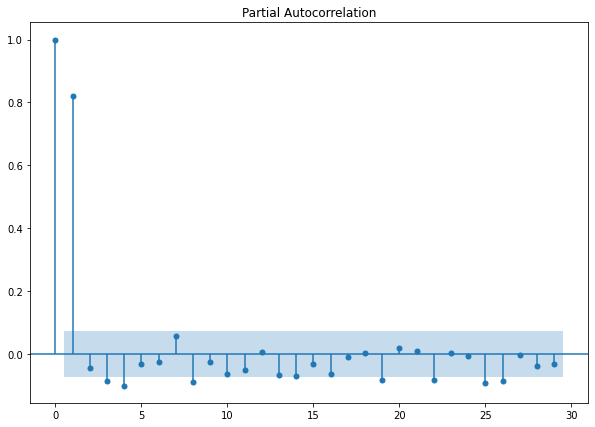

In [42]:
plot_acf(residual)
plot_pacf(residual)
plt.show()

> #### feedback:
> - 오... 드디어 뭔가 그럴싸한 그래프가 보인다...
> - 이것을 모델에 넣어보자.
> ##### residual은 차분이 이미 진행됐다고 판단되니 `d=0`으로 넣고, `p=1`, `q=5`를 넣어보자

#### train, test 데이터 나누기

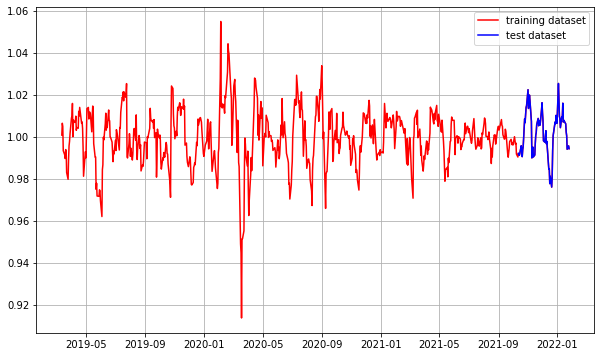

In [43]:
# train, test 데이터 나누기
train_res, test_res = residual[:int(len(residual)*0.9)], residual[int(len(residual)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(residual, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 original data를 선택
plt.plot(test_res, c='b', label='test dataset')
plt.legend()


#### ARIMA 모델 설계 및 예측

In [44]:
model = ARIMA(train_res, order=(1, 0, 5))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  653
Model:                 ARIMA(1, 0, 5)   Log Likelihood                2265.280
Date:                Wed, 16 Feb 2022   AIC                          -4514.561
Time:                        00:40:20   BIC                          -4478.708
Sample:                             0   HQIC                         -4500.657
                                - 653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9997      0.001    676.644      0.000       0.997       1.003
ar.L1          0.7328      0.082      8.884      0.000       0.571       0.894
ma.L1          0.0962      0.084      1.151      0.2

In [47]:
fc4 = fitted_m.forecast(len(test_res), alpha=0.05)  # 95% conf
fc4 = np.array(fc4)
# Make as pandas series
fc_series4 = pd.Series(fc4, index=test_res.index)   # 예측결과

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [48]:
# residual로 예측한 만큼 떨어져나간 정보가 많다.
# trend와 seasonality를 예측값에 다시 더해서 오리지널 데이터의 예측에 맞게 해본다.
# 우선 그들이 맞게 배열되어 있는지 확인해본다.
print(len(fc_series4))
print(len(trend))
print(len(seasonal))

73
756
756


In [49]:
# 더해줄 시리즈들의 인덱스를 확인해본다.
print(fc_series4.index[-10:])
print(trend.index[-10:])
print(seasonal.index[-10:])

DatetimeIndex(['2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14',
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-24', '2022-01-25'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2022-02-02', '2022-02-03', '2022-02-04', '2022-02-07',
               '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
               '2022-02-14', '2022-02-15'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2022-02-02', '2022-02-03', '2022-02-04', '2022-02-07',
               '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
               '2022-02-14', '2022-02-15'],
              dtype='datetime64[ns]', name='Date', freq=None)


> #### note:
> - `fc_series4`와 나머지 두 시리즈의 인덱스가 다른데 그 두 시리즈는 같은 것으로 파악된다.
> - 그리고 인덱스를 보면 중간에 끊긴 부분이 있는데 아마 주말에는 주식장이 안 열리나 보다.
> ##### 여기서 인덱스 맞는 것들만 모아서 `residual + trend + seasonality`이 되게끔 합을 구해보자

In [51]:
# 인덱스를 통해 value를 구할 수 있는지 확인해본다.
trend[trend.index[-20]]

6.900627848539264

In [52]:
# 세 값을 합친 진짜(?) 예측값을 구해보자
new_pred = []
for t, s in zip(trend.index, seasonal.index):
    if (t == s) & (t in fc_series4.index):
        new_pred.append(fc_series4[t] + trend[t] + seasonal[s])

In [53]:
new_pred = pd.Series(new_pred, index=fc_series4.index)
new_pred.head()

Date
2021-10-12    8.746081
2021-10-13    8.762484
2021-10-14    8.779108
2021-10-15    8.797542
2021-10-18    8.811583
dtype: float64

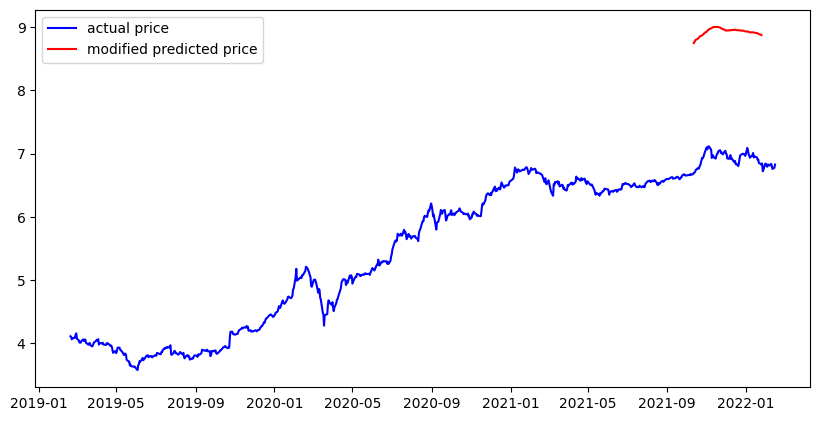

In [54]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(tsla_log, c='b', label='actual price')
plt.plot(new_pred, c='r',label='modified predicted price')
plt.legend()
plt.show()

In [55]:
# tsla_log도 현재 인덱스가 new_pred와 맞지 않다.
# new_pred와 같은 인덱스의 tsla_log 값들만 가져와서 수치적인 비교를 할 수 있게 준비한다.
ac_tsla = []
for i in tsla_log.index:
    if i in new_pred.index:
        ac_tsla.append(tsla_log[i])

print(len(ac_tsla), len(new_pred))

new_tsla = pd.Series(ac_tsla, index=new_pred.index)
new_tsla.head()

73 73


Date
2021-10-12    6.691736
2021-10-13    6.698367
2021-10-14    6.707253
2021-10-15    6.737003
2021-10-18    6.768620
dtype: float64

In [56]:
stats(new_pred, new_tsla)

MSE:  42334789.35326933
MAE:  6496.834380077436
RMSE:  6506.5189889271305
MAPE: 86.27%


(42334789.35326933, 6496.834380077436, 6506.5189889271305, 0.8626676140670514)

> #### feedback:
> - MAPE가 어마어마하다..........
> - 눈으로 봐도 확연히 차이가 났는데, 아마 저런 식으로 계산하는 모델이 아닌가보다.....
> - 오늘의 exploration은 여기서 멈추려 한다......

## 회고

#### Point 1) 로그 변환
- 맨 처음 로그 변환에 대한 제안이 있어서 원본 데이터의 추이를 그래프로 확인 후 `분산`을 줄이기 위해 로그 변환을 시도해봤다.
- 하지만 로그 변환 이후로도 정성적으로는 분산이 줄어든 것 같지 않았었다.
- 궁금해서 로그 변환에 대해 찾아 보니 시계열 데이터에서는 로그 변환이 많이 사용되고 있지만, 분산을 안정적으로 해주지 않으면 forecast에 오히려 악영향을 줄 수도 있다는 의견이 있었다.
- 나중에 이 프로젝트가 기억이 난다면 로그 변환하지 않은 데이터로도 한 번 어떤 예측 결과가 나오는지 테스트해보고 싶다.
- https://www.researchgate.net/publication/45134705_The_role_of_the_log_transformation_in_forecasting_economic_variables

#### Point 2) ARIMA 모델에 넣는 데이터는?
- 아직도 헷갈린다.
- ts_log를 넣는 건지 아님 residual을 넣는 건지...(안정적인 시계열 데이터를 넣으라고 이해했는데, 막상 LMS 노드나 여기저기 블로그를 보면 ts_log를 넣는다. 이럴 거면 왜 residual까지 깊게 들어가서 안정성을 확인해보려 했는지 잘 이해가 안 간다;;)
- 그리고 그것들에 맞춰 ARIMA 모델의 변수 p, d, q는 각각 어떻게 정하면 되는 건지 솔직히 아직 정확히 정립되지 않은 느낌이다.
- 그래서 이번 프로젝트는 다른 것보다 이론적인 개념을 정립하는 것에 시간을 굉장히 많이 썼다._(덕분에 많이 알게 되어 그 점은 감사하다!)_
- **결론적으로 내가 이해한 바는 안정성을 가진 데이터를 ARIMA 모델에 넣어야 하는데, 그것에 맞는 `p, d, q`는 내가 아직 파악되지 않은 방법론을 통해 구하는 것이고, 원본 데이터에서 변환을 시켜준 수치는 각각에 맞게 다시 복원 시켜줘야 나름의 예측값을 내는 time series analysis가 된다**는 것이다.

#### Point 3) time series 데이터의 대표주자
- 이번에 처음으로 time series 데이터라는 것을 알게 됐는데 사실 이전부터 주식 데이터 - 시계열 관련한 얘기는 조금씩 들어왔었다.
- 그런데 이번에 `안정성`을 확인하고 구해보려는 노력을 하면서 깨닫게 됐는데, 정말 주식 데이터는 time step만 있을 뿐 time series analysis를 하기에 어려운 데이터라는 생각이 들었다.(외부 요소의 영향이 강하다 보니...)
- 과연 이것으로 진짜 비슷한 예측값을 만들어내는 사람이 있을까?
- 그런데 개인적으로 스타트업 근무를 하면서 느꼈던 바로는 스타트업에서는 이런 시계열 데이터 + $\alpha$가 들어간 예측을 굉장히 하고 싶다는 것이다.(적어도 내가 있던 곳은 그랬다.)
- 특히 매출을 담당하는 부서는 그나마 있는 과거 지표를 통해 자신들이 이번달, 그리고 앞으로 낼 수 있는 매출 데이터를 뽑아내길 원하는데, 지금 생각해 보니 여기는 시계열 데이터 이외에 + $\alpha$ 데이터가 반드시 필요하다.
- 아마 그런 쪽으로 고민해서 나온 이론들이 분명 있을 텐데 실제로 다른 분들은 어떻게 그 + $\alpha$ 데이터를 정량적으로 정리하고 예측에 포함시키시는지 궁금하다.